<center>
  <h1><b>A Closed Form Solution to Natural Image Matting </b></h1>
  <br>
  MVA : Reproductible research project
  <br>
  <br>
  <b>Student Name:</b> Aissa Abdelaziz, Mahdi Ranjbar,  Mohammad Ali Jauhar
  <br>
  <br>
  </center>

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_input = r"Desktop\MVA\Image-Matting-with-A-Closed-Form-Solution\input.png"
image_input = cv2.imread(image_input, cv2.IMREAD_COLOR) 
image=image_input/ 255.0

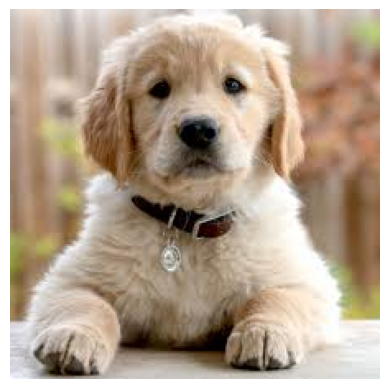

In [2]:
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

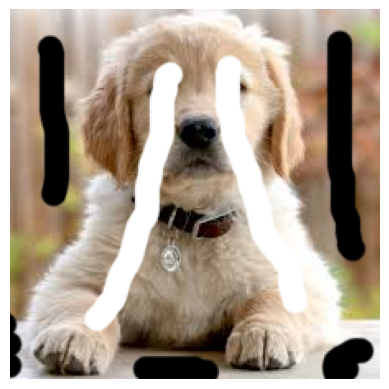

In [3]:
#Scribles
image_scribles = r"MVA\Image-Matting-with-A-Closed-Form-Solution\scribles.png"
image_scribles =cv2.imread(image_scribles, cv2.IMREAD_COLOR) 
#image_scribles=image_input

scribbles=image_scribles/ 255.0
plt.imshow(cv2.cvtColor(image_scribles, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

In [27]:
import numpy as np
#We calculate the initial assumption
prior = np.sign(np.sum(image - scribbles, axis=2)) / 2 + 0.5
print(prior)

[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [1.  1.  1.  ... 0.5 0.5 0.5]
 [1.  1.  1.  ... 0.5 0.5 0.5]
 [1.  1.  1.  ... 0.5 0.5 0.5]]


In [28]:
#Constant map 
consts_map = prior != 0.5
print(consts_map)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


The elements of the matting Laplacian :  
\begin{align}
L(i, j)=\sum_{k \mid(i, j) \in w_k}\left[\delta_{i j}-\frac{1}{W}\left(1+\left(I_i-\mu_k\right)^{\top}\left(\Sigma_k+\frac{\varepsilon}{W} I_{3 \times 3}\right)^{-1}\left(I_j-\mu_k\right)\right)\right]
\end{align}

In [29]:
#we calcualte the matting laplacian 
from scipy.sparse import spdiags, csr_matrix
from scipy.ndimage import binary_erosion

def getLaplacian1(I, consts, epsilon=0.0000001, win_size=1):
    print("calculating the Laplacian ")
    neb_size = (win_size * 2 + 1) ** 2
    h, w, c = I.shape
    img_size = w * h
    consts = binary_erosion(consts, structure=np.ones((win_size * 2 + 1, win_size * 2 + 1)))
    indsM = np.arange(img_size).reshape(h, w)
    tlen = int(((1 - consts[win_size:-win_size, win_size:-win_size]).sum()) * (neb_size ** 2))
    row_inds = np.zeros(tlen)
    col_inds = np.zeros(tlen)
    vals = np.zeros(tlen)
    len_ = 0
    for j in range(win_size, w - win_size):
        for i in range(win_size, h - win_size):
            if consts[i, j]:
               continue
            win_inds = indsM[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1]
            win_inds = win_inds.flatten()
            winI = I[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1, :]
            winI = winI.reshape(neb_size, c)
            win_mu = np.mean(winI, axis=0)
            win_var = np.linalg.inv(winI.T @ winI / neb_size - np.outer(win_mu, win_mu) + epsilon / neb_size * np.eye(c))
            winI = winI - win_mu
            tvals = (1 + winI @ win_var @ winI.T) / neb_size
            
            row_inds[len_:len_ + neb_size ** 2] = np.repeat(win_inds, neb_size)
            col_inds[len_:len_ + neb_size ** 2] = np.tile(win_inds, neb_size)
            vals[len_:len_ + neb_size ** 2] = tvals.flatten()
            len_ += neb_size ** 2
    vals = vals[:len_]
    row_inds = row_inds[:len_]
    col_inds = col_inds[:len_]
    A = csr_matrix((vals, (row_inds, col_inds)), shape=(img_size, img_size))
    sumA = A.sum(axis=1)
    A = spdiags(sumA.flatten(), 0, img_size, img_size) - A
    return A

In [30]:
#Apply the function 
laplacian = getLaplacian1(image, consts_map)
print(laplacian)

calculating the Laplacian 
  (0, 0)	0.8888888888888888
  (0, 1)	-0.11111111111111177
  (0, 2)	-0.11111111111111313
  (0, 225)	-0.11111111111111044
  (0, 226)	-0.1111111111111111
  (0, 227)	-0.11111111111111246
  (0, 450)	-0.11111111111110909
  (0, 451)	-0.11111111111110977
  (0, 452)	-0.1111111111111111
  (1, 0)	-0.11111111111111177
  (1, 1)	1.7228362888439857
  (1, 2)	-0.3101268183278636
  (1, 3)	-0.03419124041537222
  (1, 225)	-0.07539958985125325
  (1, 226)	-0.2606821575700916
  (1, 227)	-0.2936452647419396
  (1, 228)	-0.05342120808930695
  (1, 450)	-0.003976547331535518
  (1, 451)	-0.22771905039824347
  (1, 452)	-0.2606821575700916
  (1, 453)	-0.09188114343717621
  (2, 0)	-0.11111111111111313
  (2, 1)	-0.31012681832785827
  (2, 2)	2.2694936777028913
  (2, 3)	-0.3374003050780725
  :	:
  (50622, 50621)	-0.1389819724954849
  (50622, 50622)	1.2931743671859552
  (50622, 50623)	-0.8802690470911652
  (50622, 50624)	0.07288278599889692
  (50623, 50171)	0.009277757681660552
  (50623, 50172)

In [31]:
import scipy.sparse
import scipy.sparse.linalg


scribbles_confidence=100
#prior_confidence contains the confidence values where consts_map is True, and zero otherwise
prior_confidence = scribbles_confidence * consts_map
print(prior_confidence)


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [100 100 100 ...   0   0   0]
 [100 100 100 ...   0   0   0]
 [100 100 100 ...   0   0   0]]


In [32]:
#converts prior_confidence matrix into a sparse diagonal matrix 
confidence = scipy.sparse.diags(prior_confidence.flatten())
print(confidence)

  (2898, 2898)	100.0
  (2899, 2899)	100.0
  (2900, 2900)	100.0
  (2901, 2901)	100.0
  (2902, 2902)	100.0
  (3121, 3121)	100.0
  (3122, 3122)	100.0
  (3123, 3123)	100.0
  (3124, 3124)	100.0
  (3125, 3125)	100.0
  (3126, 3126)	100.0
  (3127, 3127)	100.0
  (3128, 3128)	100.0
  (3129, 3129)	100.0
  (3344, 3344)	100.0
  (3345, 3345)	100.0
  (3346, 3346)	100.0
  (3347, 3347)	100.0
  (3348, 3348)	100.0
  (3349, 3349)	100.0
  (3350, 3350)	100.0
  (3351, 3351)	100.0
  (3352, 3352)	100.0
  (3353, 3353)	100.0
  (3354, 3354)	100.0
  :	:
  (50523, 50523)	100.0
  (50524, 50524)	100.0
  (50525, 50525)	100.0
  (50526, 50526)	100.0
  (50590, 50590)	100.0
  (50591, 50591)	100.0
  (50592, 50592)	100.0
  (50593, 50593)	100.0
  (50594, 50594)	100.0
  (50595, 50595)	100.0
  (50596, 50596)	100.0
  (50597, 50597)	100.0
  (50598, 50598)	100.0
  (50599, 50599)	100.0
  (50600, 50600)	100.0
  (50601, 50601)	100.0
  (50602, 50602)	100.0
  (50603, 50603)	100.0
  (50604, 50604)	100.0
  (50605, 50605)	100.0
  (50606,

In [33]:
#Computes the solution of the linear system
solution = scipy.sparse.linalg.spsolve(laplacian + confidence,prior.flatten() * prior_confidence.flatten())

In [35]:
#Ensure that the result lie within the range [0, 1]
alpha = np.clip(solution.reshape(prior.shape), 0, 1)

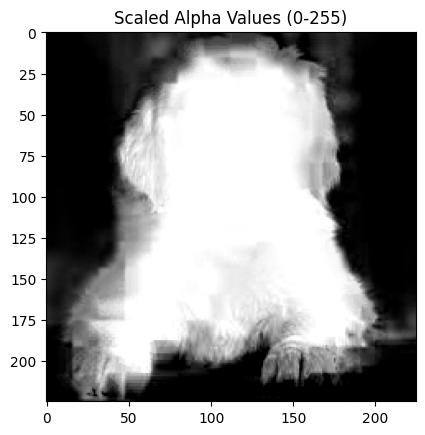

In [36]:
# Plot the scaled alpha values
plt.imshow((1-alpha) * 255, cmap='gray')  # Display as grayscale
plt.title('Scaled Alpha Values (0-255)')
plt.show()

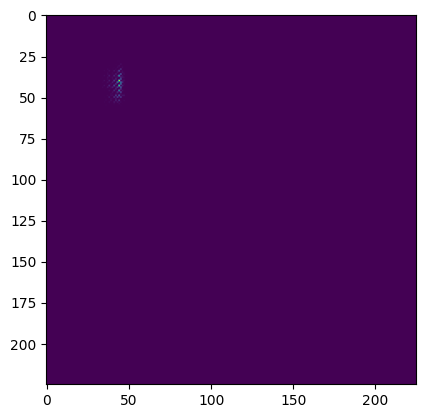

In [37]:
# Plotting eigenvalues and eigenvectors
eig_vals, eig_vecs = scipy.sparse.linalg.eigs(laplacian)
plt.imshow(np.clip(eig_vecs.real.T[1].reshape(prior.shape), 0, 1))
plt.show()